My final will be utilizing the Adult Income Dataset from 

Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

The goal is to find a supervised model that will generate the highest prediction and accuracy score in determining if someone makes >50K depending on certain features. We will be referencing between UCI ML Repository and Kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-income-dataset/adult.csv


Here we are pulling the dataset from Kaggle; however, we will be referencing UCI Repository for expected results and documentation

In [2]:
#read the adult dataset from .csv file
data = pd.read_csv('/kaggle/input/adult-income-dataset/adult.csv', na_values=['?'])

data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
#creating DataFrame
df = pd.DataFrame(data)

#dropping unused columns and rows with missing values
df = df.drop(['fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], axis=1)
df.dropna(inplace=True)
df

,age,workclass,education,marital-status,occupation,relationship,race,gender,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,>50K
5,34,Private,10th,Never-married,Other-service,Not-in-family,White,Male,<=50K
...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,<=50K
48838,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,>50K
48839,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,<=50K
48840,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,<=50K


We will need to convert the former object types into numerical references for the training model. We will assign each variable under [0,1,2...]

In [4]:
#changing all values in dataset to integers for RF 
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

df['workclass'] = df['workclass'].map({'Self-emp-inc': 0, 'State-gov': 1,'Federal-gov': 2, 'Without-pay': 3, 'Local-gov': 4,'Private': 5, 'Self-emp-not-inc': 6}).astype(int)
df['education'] = df['education'].map({'Some-college': 0, 'Preschool': 1, '5th-6th': 2, 'HS-grad': 3, 'Masters': 4, '12th': 5, '7th-8th': 6, 'Prof-school': 7,'1st-4th': 8, 'Assoc-acdm': 9, 'Doctorate': 10, '11th': 11,'Bachelors': 12, '10th': 13,'Assoc-voc': 14,'9th': 15}).astype(int)
df['marital-status'] = df['marital-status'].map({'Married-spouse-absent': 0, 'Widowed': 1, 'Married-civ-spouse': 2, 'Separated': 3, 'Divorced': 4,'Never-married': 5, 'Married-AF-spouse': 6}).astype(int)
df['occupation'] = df['occupation'].map({ 'Farming-fishing': 1, 'Tech-support': 2, 'Adm-clerical': 3, 'Handlers-cleaners': 4, 
 'Prof-specialty': 5,'Machine-op-inspct': 6, 'Exec-managerial': 7,'Priv-house-serv': 8,'Craft-repair': 9,'Sales': 10, 'Transport-moving': 11, 'Armed-Forces': 12, 'Other-service': 13,'Protective-serv':14}).astype(int)
df['relationship'] = df['relationship'].map({'Not-in-family': 0, 'Wife': 1, 'Other-relative': 2, 'Unmarried': 3,'Husband': 4,'Own-child': 5}).astype(int)
df['race'] = df['race'].map({'Black': 0, 'Asian-Pac-Islander': 1, 'Other': 2, 'White': 3, 'Amer-Indian-Eskimo': 4}).astype(int)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1}).astype(int)
df

,age,workclass,education,marital-status,occupation,relationship,race,gender,income
0,25,5,11,5,6,5,0,0,0
1,38,5,3,2,1,4,3,0,0
2,28,4,9,2,14,4,3,0,1
3,44,5,0,2,6,4,0,0,1
5,34,5,13,5,13,0,3,0,0
...,...,...,...,...,...,...,...,...,...
48837,27,5,9,2,2,1,3,1,0
48838,40,5,3,2,6,4,3,0,1
48839,58,5,3,1,3,3,3,1,0
48840,22,5,3,5,3,5,3,0,0


Here, we will split the dataset into 80:20, .80 of the data will be utilized for training the model, while .20 (default) will be used to test the model and generate y_pred. 

In [5]:
# Split the data into features and target
X = df.drop('income', axis=1)
y = df['income']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
#build the RandomForest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)

print("Random Forest Score: " + str(rf_score))
#get prediction
y_pred = rf.predict(X_test)


# Confusion matrix for visualization
confusion_matrix(y_test, y_pred)

Random Forest Score: 0.8013468013468014


array([[6106,  767],
       [1062, 1272]])

In [7]:
#calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

Accuracy: 0.8013468013468014
Precision: 0.6238352133398725


In [8]:
# Classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      6873
           1       0.62      0.54      0.58      2334

    accuracy                           0.80      9207
   macro avg       0.74      0.72      0.73      9207
weighted avg       0.79      0.80      0.80      9207



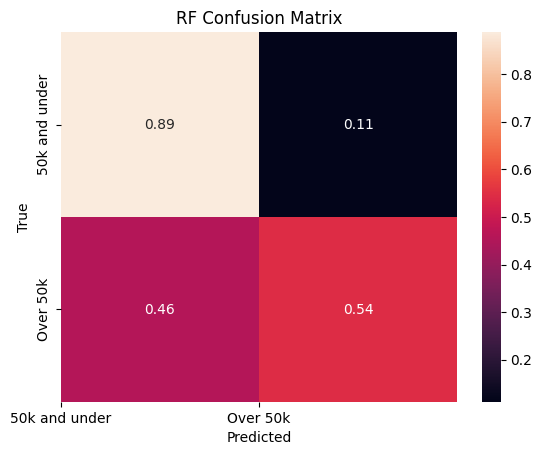

In [9]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

#Generate Plot
plt.figure()
sns.heatmap(matrix, annot=True, annot_kws={'size':10})

# Plot the CM
incomes = ['50k and under', 'Over 50k']
tick = np.arange(len(incomes))
tick2 = tick + 0.5
plt.xticks(tick, incomes)
plt.yticks(tick2, incomes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RF Confusion Matrix')
plt.show()

Let's check RF against a single Decision Tree model. We will almost always prefer a RF over DT

In [10]:
# Creating DT Classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

#Fit the model
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

#Print accuracy
print("Accuracy:" + str(accuracy_score(y_test, y_pred)))


Accuracy:0.7808189421092647


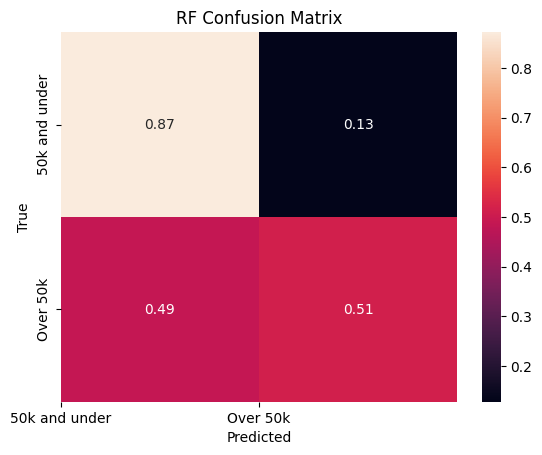

In [11]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure()
sns.heatmap(matrix, annot=True, annot_kws={'size':10})

# Add labels to the plot
incomes = ['50k and under', 'Over 50k']
tick = np.arange(len(incomes))
tick2 = tick + 0.5
plt.xticks(tick, incomes)
plt.yticks(tick2, incomes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RF Confusion Matrix')
plt.show()

Although there are several features in this dataset, AdaBoost would perform well for the amount of features we have in our DataFrame. We will calculate the accuracy for Boosting methods

In [12]:
#import AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#Create Adaboost model
ada = AdaBoostClassifier()
model = ada.fit(X_train, y_train)

#Predict the response for test dataset
y_pred1 = model.predict(X_test)

#calculate accuracy
accuracyAda = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracyAda)

#calculate precision
precisionAda = precision_score(y_test, y_pred1)
print("Precision:", precisionAda)

Accuracy: 0.8153578798740089
Precision: 0.673224043715847


As we can see, AdaBoost performed slighly more accurate against RF. While both models would be great choices for predicting the question, AdaBoost performed better overall

Lastly, I've included logistic regression for comparison. Unfortunately, this model does not produce as great as results. This could be a result of the various features that need to be accounted for.

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Linear Regression Scores: " + str(lr_score))

Linear Regression Scores: 0.7508417508417509


In conclusion, while RandomForest and Boosting Models (in this case, AdaBoosting) both generate similar accuracy, using Boosting would best predict individuals making above 50k. 